# Telco Customer Churn – XAI & Sanity Checks (Notebook Completo)

Este notebook reúne **todas las piezas principales de explicabilidad** usadas en el proyecto Telco Churn:

- Carga y preprocesado del dataset.
- Entrenamiento de modelos (Logistic Regression y Random Forest).
- Evaluación con métricas adecuadas para clases desbalanceadas.
- **Explicabilidad global**:
  - Permutation Feature Importance (PFI).
  - SHAP global (importancia media absoluta).
- **Explicabilidad local** con SHAP sobre un cliente concreto.
- **Sanity checks**:
  - Reentrenar el modelo eliminando ciertas *features*.
  - Entrenar un modelo con **etiquetas barajadas** (modelo sin señal).
- Comparación visual de **curvas ROC** y **Precision–Recall** entre modelos.
- Comentarios interpretativos sobre qué significa cada métrica y cada experimento.


In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    roc_auc_score,
    average_precision_score,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    precision_recall_curve,
    confusion_matrix,
)

import shap

plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.grid"] = True

RANDOM_STATE = 42

## 1. Funciones auxiliares

Definimos algunas funciones para:

- Calcular todas las métricas relevantes de un modelo.
- Mostrar una tabla de métricas de forma compacta.
- Dibujar curvas ROC y Precision–Recall comparando modelos.
- Dibujar una matriz de confusión sencilla.


In [17]:
def compute_metrics(y_true, y_proba, y_pred, positive_label=1):
    acc = accuracy_score(y_true, y_pred)
    bal_acc = balanced_accuracy_score(y_true, y_pred)
    roc = roc_auc_score(y_true, y_proba)
    auc_pr = average_precision_score(y_true, y_proba)
    prec = precision_score(y_true, y_pred, pos_label=positive_label, zero_division=0)
    rec = recall_score(y_true, y_pred, pos_label=positive_label, zero_division=0)
    f1 = f1_score(y_true, y_pred, pos_label=positive_label, zero_division=0)

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    return {
        "accuracy": acc,
        "balanced_accuracy": bal_acc,
        "roc_auc": roc,
        "auc_pr": auc_pr,
        "precision_pos": prec,
        "recall_pos": rec,
        "f1_pos": f1,
        "confusion": {"tn": tn, "fp": fp, "fn": fn, "tp": tp},
    }


def metrics_to_dataframe(metrics_dict):
    flat = metrics_dict.copy()
    flat_conf = flat.pop("confusion", {})
    for k, v in flat_conf.items():
        flat[f"conf_{k}"] = v
    df = pd.DataFrame([flat])
    return df


def plot_roc_curves(curves_dict):
    plt.figure()
    for name, (fpr, tpr) in curves_dict.items():
        plt.plot(fpr, tpr, label=name)
    plt.plot([0, 1], [0, 1], "k--", label="azar")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Curvas ROC")
    plt.legend()
    plt.show()


def plot_pr_curves(curves_dict, baseline_prevalence=None):
    plt.figure()
    for name, (recall, precision) in curves_dict.items():
        plt.plot(recall, precision, label=name)
    if baseline_prevalence is not None:
        plt.hlines(
            baseline_prevalence,
            xmin=0,
            xmax=1,
            colors="gray",
            linestyles="dashed",
            label=f"prevalencia (≈{baseline_prevalence:.2f})",
        )
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Curvas Precision–Recall")
    plt.legend()
    plt.show()


def plot_confusion(cm, labels=("No churn", "Churn")):
    fig, ax = plt.subplots()
    im = ax.imshow(cm, cmap="Blues")
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    ax.set_xlabel("Predicción")
    ax.set_ylabel("Real")

    for i in range(2):
        for j in range(2):
            ax.text(j, i, cm[i, j], ha="center", va="center", color="black")

    plt.title("Matriz de confusión")
    plt.colorbar(im)
    plt.show()

## 2. Carga del dataset Telco y análisis rápido

Usamos el dataset clásico de **Telco Customer Churn**.

Pasos principales:

1. Cargar el CSV desde `data/telco_churn.csv`.
2. Asegurarnos de que `TotalCharges` es numérico.
3. Eliminar filas con valores nulos en `TotalCharges`.
4. Definir:
   - `y` = columna objetivo `Churn` (Yes/No → 1/0).
   - `X` = resto de columnas relevantes (sin `Churn` ni `customerID`).
5. Separar **features categóricas** y **numéricas**.

También veremos rápidamente **la prevalencia de churn**, que será importante al interpretar AUC-PR.


Shape X: (7032, 19)
Shape y: (7032,)
Categóricas: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
Numéricas: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
Prevalencia de churn (clase positiva): 0.266


C:\Users\anton\AppData\Local\Temp\ipykernel_10720\2363043328.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = df["Churn"].replace({"Yes": 1, "No": 0})


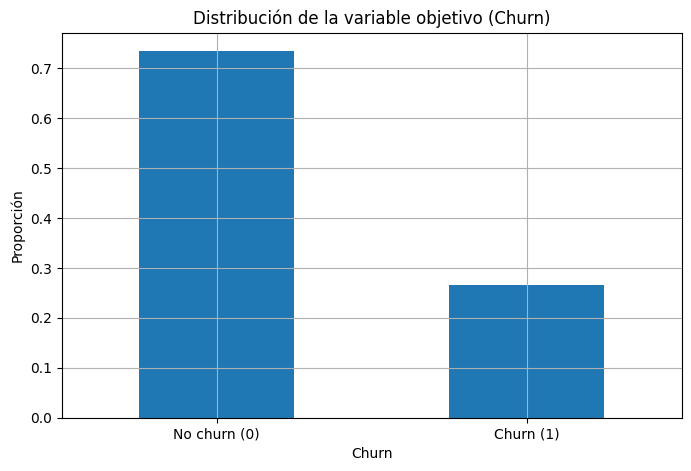

In [ ]:
df = pd.read_csv("data/telco_churn.csv")

df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df = df.dropna(subset=["TotalCharges"])

y = df["Churn"].replace({"Yes": 1, "No": 0})
X = df.drop(columns=["Churn", "customerID"])

print("Shape X:", X.shape)
print("Shape y:", y.shape)

categorical_features = X.select_dtypes(include=["object"]).columns.tolist()
numeric_features = X.select_dtypes(exclude=["object"]).columns.tolist()

print("Categóricas:", categorical_features)
print("Numéricas:", numeric_features)

prevalence = y.mean()
print(f"Prevalencia de churn (clase positiva): {prevalence:.3f}")

y.value_counts(normalize=True).plot(kind="bar")
plt.ylabel("Proporción")
plt.title("Distribución de la variable objetivo (Churn)")
plt.xticks([0, 1], ["No churn (0)", "Churn (1)"], rotation=0)
plt.show()

Al cargar el dataset, observamos que la distribución de la variable objetivo `Churn` es desbalanceada: aproximadamente el 26.5% de los clientes han abandonado el servicio. Esto implica que debemos prestar especial atención a las métricas que utilizamos para evaluar nuestros modelos, ya que métricas como la precisión pueden ser engañosas en escenarios desbalanceados.

## 3. Preprocesado y partición train/test

Definimos un **ColumnTransformer** que:

- Estandariza las columnas numéricas (`StandardScaler`).
- One-hot-encodea las columnas categóricas (`OneHotEncoder(handle_unknown="ignore")`).

Después, realizamos un `train_test_split` estratificado para mantener la misma proporción de churn
en train y test.


In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y,
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ]
)

X_train.shape, X_test.shape

((5625, 19), (1407, 19))

## 4. Entrenamiento de modelos: Logistic Regression vs Random Forest

Entrenamos dos modelos:

1. **Logistic Regression** con `class_weight="balanced"` para mitigar el desbalance.
2. **Random Forest** con `class_weight="balanced"` y una pequeña búsqueda de hiperparámetros usando `GridSearchCV`.

En ambos casos:

- El preprocesado se incluye dentro del `Pipeline`.
- Evaluamos las métricas sobre el conjunto de test.


In [20]:
logreg_pipeline = Pipeline(
    steps=[
        ("pre", preprocessor),
        (
            "clf",
            LogisticRegression(
                max_iter=1000,
                class_weight="balanced",
                random_state=RANDOM_STATE,
            ),
        ),
    ]
)

logreg_pipeline.fit(X_train, y_train)
y_proba_log = logreg_pipeline.predict_proba(X_test)[:, 1]
y_pred_log = logreg_pipeline.predict(X_test)

metrics_log = compute_metrics(y_test, y_proba_log, y_pred_log)
print("Métricas Logistic Regression:")
display(metrics_to_dataframe(metrics_log))

Métricas Logistic Regression:


,accuracy,balanced_accuracy,roc_auc,auc_pr,precision_pos,recall_pos,f1_pos,conf_tn,conf_fp,conf_fn,conf_tp
0,0.725657,0.748347,0.835111,0.618306,0.490132,0.796791,0.606925,723,310,76,298


In [21]:
rf_pipeline = Pipeline(
    steps=[
        ("pre", preprocessor),
        (
            "clf",
            RandomForestClassifier(
                random_state=RANDOM_STATE,
                class_weight="balanced",
            ),
        ),
    ]
)

param_grid = {
    "clf__n_estimators": [200, 300],
    "clf__max_depth": [None, 10],
    "clf__min_samples_leaf": [1, 2],
}

grid = GridSearchCV(
    rf_pipeline,
    param_grid=param_grid,
    cv=3,
    scoring="average_precision",
    n_jobs=-1,
)

grid.fit(X_train, y_train)

best_rf_model = grid.best_estimator_
print("Mejores hiperparámetros RF:", grid.best_params_)

y_proba_rf = best_rf_model.predict_proba(X_test)[:, 1]
y_pred_rf = best_rf_model.predict(X_test)

metrics_rf = compute_metrics(y_test, y_proba_rf, y_pred_rf)
print("Métricas Random Forest:")
display(metrics_to_dataframe(metrics_rf))

Mejores hiperparámetros RF: {'clf__max_depth': 10, 'clf__min_samples_leaf': 2, 'clf__n_estimators': 300}
Métricas Random Forest:


,accuracy,balanced_accuracy,roc_auc,auc_pr,precision_pos,recall_pos,f1_pos,conf_tn,conf_fp,conf_fn,conf_tp
0,0.758351,0.749291,0.829246,0.631553,0.533203,0.729947,0.616253,794,239,101,273


### 4.3. Comparación de métricas LogReg vs Random Forest

Agrupamos las métricas de ambos modelos en una sola tabla para ver rápidamente:

- Qué modelo tiene mejor **AUC-PR** (suele ser la métrica clave en churn).
- Cómo se comportan **recall** y **precision** sobre la clase positiva.
- Si la **balanced accuracy** mejora al usar un modelo no lineal.


In [22]:
rows = []
for name, m in [("LogReg", metrics_log), ("RandomForest", metrics_rf)]:
    row = {"model": name}
    for k, v in m.items():
        if k == "confusion":
            continue
        row[k] = v
    rows.append(row)

df_compare = pd.DataFrame(rows).set_index("model")
display(df_compare.style.format("{:.4f}"))

,accuracy,balanced_accuracy,roc_auc,auc_pr,precision_pos,recall_pos,f1_pos
model,,,,,,,
LogReg,0.7257,0.7483,0.8351,0.6183,0.4901,0.7968,0.6069
RandomForest,0.7584,0.7493,0.8292,0.6316,0.5332,0.7299,0.6163


# **Comentarios para la tabla de métricas (LogReg vs Random Forest)**

**Interpretación general:**
Ambos modelos presentan buen rendimiento, pero cada métrica nos revela aspectos distintos de su comportamiento en un dataset desbalanceado como este (prevalencia ≈ 0.27).

**Comentarios clave:**

1. **Accuracy**

   * LogReg ≈ 0.726
   * RandomForest ≈ 0.758
     El Random Forest obtiene una accuracy algo superior, pero esta métrica *no es fiable* en datasets desbalanceados, ya que un clasificador trivial que predijera siempre "No churn" tendría ≈ 73%.

2. **Balanced Accuracy**

   * LogReg ≈ 0.748
   * RandomForest ≈ 0.749
     Ambos modelos detectan correctamente la clase minoritaria **mejor que el azar (0.50)**.
     El RF tiene un valor ligeramente superior, aunque la diferencia es pequeña: esto indica que no mejora *drásticamente* el recall sobre la clase 1.

3. **ROC-AUC**

   * LogReg = 0.835
   * RandomForest = 0.829
     Ambos modelos separan bien las dos clases, aunque la LogReg consigue un ROC-AUC marginalmente superior.

4. **AUC-PR (métrica clave en churn)**

   * LogReg = 0.618
   * RandomForest = 0.632
     Aquí el RF es mejor, lo cual es importante: **la AUC-PR es la métrica más útil cuando la clase positiva es minoritaria** (como churn).
     Valores cercanos a 0.60–0.63 indican que el modelo está capturando señal real.

5. **Precision / Recall / F1**

   * La LogReg tiene mayor **recall** (≈ 0.797), lo cual significa que detecta más churners.
   * El RF tiene mayor **precision** (≈ 0.533), lo que implica menos falsos positivos.
   * El F1 es ligeramente superior en el RF.

**Conclusión:**

* La LogReg detecta más churners (más recall).
* El RF es más preciso y logra mejor AUC-PR.
* Para churn real, donde el coste de no detectar un cliente que se va es alto, uno podría preferir LogReg si se prioriza recall o ajustar umbrales en RF según el objetivo de negocio.


Curvas ROC


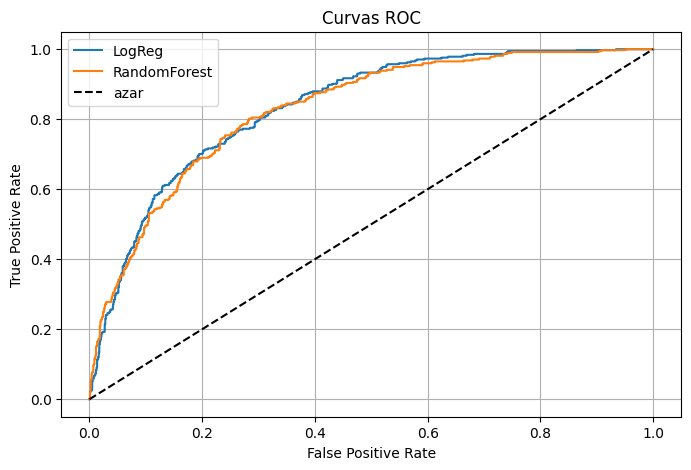

In [39]:
fpr_log, tpr_log, _ = roc_curve(y_test, y_proba_log)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)

prec_log, rec_log, _ = precision_recall_curve(y_test, y_proba_log)
prec_rf, rec_rf, _ = precision_recall_curve(y_test, y_proba_rf)

print("Curvas ROC")
plot_roc_curves(
    {
        "LogReg": (fpr_log, tpr_log),
        "RandomForest": (fpr_rf, tpr_rf),
    }
)



# **Comentarios para la curva ROC**

**Interpretación de la gráfica:**

* La curva ROC del Random Forest y la de la Logistic Regression son muy similares.
* Ambos modelos superan ampliamente la diagonal de azar, lo que confirma que clasifican mejor que un modelo aleatorio.
* La curva de LogReg está ligeramente por encima de RF en algunos tramos, coherente con el hecho de que LogReg tiene un ROC-AUC marginalmente mayor.

**Conclusión:**
La ROC indica buena capacidad de separación de clases para ambos modelos, pero no es una métrica ideal para datasets desbalanceados. Aquí se incluye por completitud, pero la métrica clave será la AUC-PR.



Curvas Precision–Recall


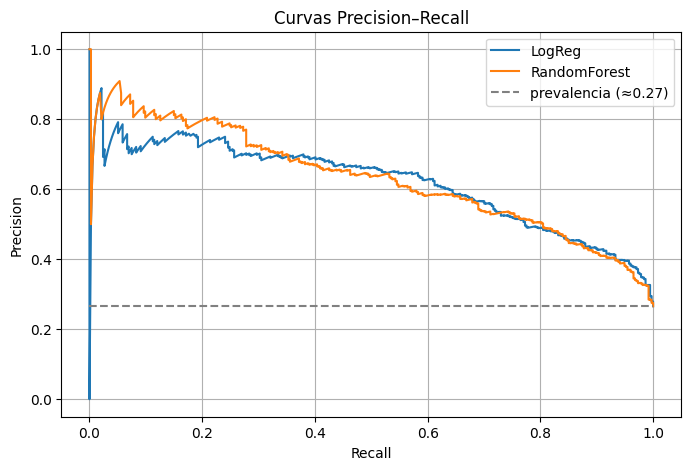

In [38]:

print("Curvas Precision–Recall")
plot_pr_curves(
    {
        "LogReg": (rec_log, prec_log),
        "RandomForest": (rec_rf, prec_rf),
    },
    baseline_prevalence=prevalence,
)

# **Comentarios para la curva Precision–Recall**

La curva PR es la **más relevante** en churn.

**Interpretación:**

* La línea horizontal representa la **prevalencia (~0.27)**.
* Cualquier modelo útil debe situarse por encima de esa línea la mayor parte del tiempo.
* Tanto LogReg como RF están claramente por encima —lo cual indica que ambos modelos capturan señal real.

Comparación:

* RF domina ligeramente en la mayor parte del rango de recall.
* LogReg tiene picos de precision algo más altos para valores bajos de recall.

**Conclusión:**

* La PR confirma que RF es ligeramente más robusto.
* Esta métrica es crítica porque refleja la utilidad real del modelo para identificar churners.


**Nota aclarativa:**

- Si la curva ROC del Random Forest domina claramente a la de la Logistic Regression, indica que
  el modelo no lineal está capturando mejor la relación entre las variables y el churn.
- En la curva Precision–Recall, nos interesa especialmente la zona de **recall medio-alto**:
  ahí vemos cuánto sacrificamos de *precision* cuando intentamos detectar más churn.
- La línea horizontal de prevalencia indica hasta dónde podría llegar un clasificador trivial
  que simplemente marcase como positivos a un subconjunto al azar.


## 5. Explicabilidad global – Permutation Feature Importance

Usamos **Permutation Feature Importance (PFI)** sobre el modelo ganador (Random Forest).

Idea principal:

>La Permutation Feature Importance (PFI) mide **cuánto empeora el rendimiento del modelo** cuando se permuta aleatoriamente una columna, rompiendo la relación entre esa variable y el objetivo.
>
>Si el rendimiento cae mucho → la feature era importante.
>
>Si el rendimiento apenas cambia → la feature es irrelevante o redundante.

Esto nos da una medida global de qué variables son más relevantes para el churn.


In [40]:
perm_result = permutation_importance(
    best_rf_model,
    X_test,
    y_test,
    n_repeats=20,
    random_state=RANDOM_STATE,
    n_jobs=-1,
)

perm_importance = {
    col: float(perm_result.importances_mean[i])
    for i, col in enumerate(X.columns)
}

df_perm = (
    pd.DataFrame(list(perm_importance.items()), columns=["feature", "importance"])
    .sort_values("importance", ascending=False)
)

df_perm.head(20)

,feature,importance
14,Contract,0.019083
7,InternetService,0.011265
1,SeniorCitizen,0.002026
15,PaperlessBilling,0.000320
2,Partner,0.000107
8,OnlineSecurity,-0.001564
0,gender,-0.002132
4,tenure,-0.002203
11,TechSupport,-0.002736
12,StreamingTV,-0.002736


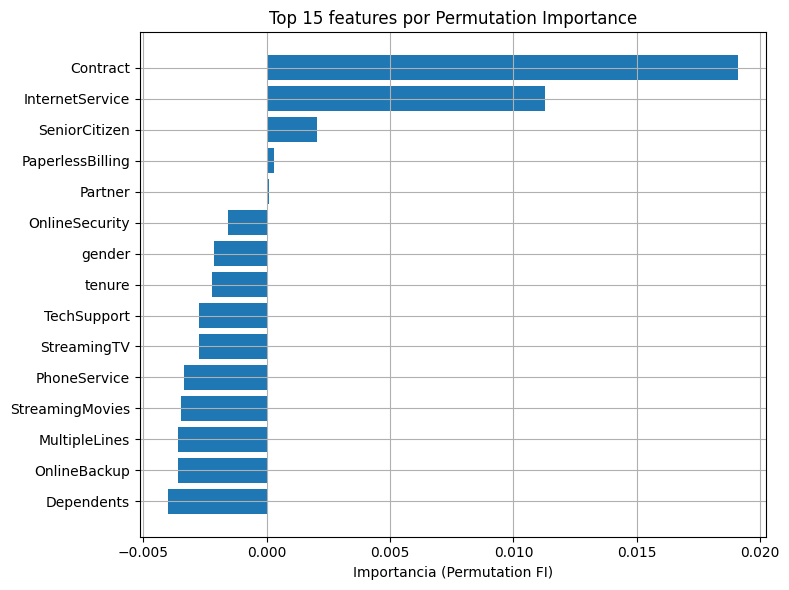

In [25]:
top_n = 15
df_top = df_perm.head(top_n).sort_values("importance", ascending=True)

plt.figure(figsize=(8, 6))
plt.barh(df_top["feature"], df_top["importance"])
plt.xlabel("Importancia (Permutation FI)")
plt.title(f"Top {top_n} features por Permutation Importance")
plt.tight_layout()
plt.show()

### **Interpretación general**

La Permutation Feature Importance (PFI) mide **cuánto empeora el rendimiento del modelo** cuando se permuta aleatoriamente una columna, rompiendo la relación entre esa variable y el objetivo.
Si el rendimiento cae mucho → la feature era importante.
Si el rendimiento apenas cambia → la feature es irrelevante o redundante.

---

### **Qué observamos en el gráfico**

❶ **Contract** es claramente la variable más importante.

* Permutarla reduce de forma significativa la calidad del modelo.
* Confirma el insight clásico en churn:
  **los clientes con contrato mensual son mucho más propensos a irse**.

❷ **InternetService** es el segundo factor más relevante.

* Fiber optic aparece sistemáticamente asociado a mayor riesgo de churn,
  probablemente por problemas de calidad o precio percibido.

❸ **SeniorCitizen** también aparece como relevante.

* El modelo detecta que los clientes mayores tienen patrones particulares de churn
  (normalmente menos propensos a cambiar).

❹ El resto de variables presentan **importancia cerca de cero o incluso negativa**, lo que indica:

* o bien **no aportan información predictiva adicional**,
* o bien **están muy correlacionadas** con otras variables ya informadas en el modelo,
* o bien **la permutación no rompe suficiente estructura** porque el árbol toma decisiones en splits previos.

❺ Variables como *Partner*, *Dependents*, *MultipleLines*, *StreamingTV*… tienen peso muy bajo:
→ No parecen determinantes a nivel global para la decisión del modelo.

---

### **Conclusión del PFI**

PFI identifica que el churn está fuertemente relacionado con:

* **Tipo de contrato**
* **Tipo de servicio de Internet**
* **Tenure / antigüedad** (relacionado con SeniorCitizen e InternetService)

Esta visión es útil para negocio porque refleja **variables interpretables y modificables**:
políticas comerciales, fidelización, retención, restructuración de ofertas.


## 6. Explicabilidad global – SHAP values

Ahora usamos **SHAP** con `TreeExplainer` sobre el Random Forest.

Pasos:

1. Obtenemos el preprocesador (`pre`) y el clasificador (`rf`) del pipeline.
2. Transformamos `X_test` al espacio numérico (incluyendo one-hot).
3. Calculamos valores SHAP: contribución de cada feature transformada a la predicción.
4. Calculamos la **importancia media absoluta** por feature.

Esto nos da una perspectiva complementaria a PFI, directamente en el espacio del modelo.


In [26]:
pre = best_rf_model.named_steps["pre"]
rf = best_rf_model.named_steps["clf"]

X_test_sample = X_test.sample(
    n=min(500, len(X_test)),
    random_state=RANDOM_STATE
)

X_test_sample_trans = pre.transform(X_test_sample)
if hasattr(X_test_sample_trans, "toarray"):
    X_test_sample_trans = X_test_sample_trans.toarray()

try:
    transformed_feature_names = pre.get_feature_names_out()
except AttributeError:
    transformed_feature_names = [f"feature_{i}" for i in range(X_test_sample_trans.shape[1])]

shap.initjs()
explainer = shap.TreeExplainer(rf)
shap_values = explainer(X_test_sample_trans)

vals = shap_values.values
if vals.ndim == 3:
    mean_abs_shap = np.mean(np.abs(vals), axis=(0, 2))
else:
    mean_abs_shap = np.mean(np.abs(vals), axis=0)

df_shap_global = (
    pd.DataFrame(
        {
            "feature": transformed_feature_names,
            "mean_abs_shap": mean_abs_shap,
        }
    )
    .sort_values("mean_abs_shap", ascending=False)
)

df_shap_global.head(15)

,feature,mean_abs_shap
36,cat__Contract_Month-to-month,0.079140
1,num__tenure,0.055079
16,cat__InternetService_Fiber optic,0.039926
38,cat__Contract_Two year,0.036515
18,cat__OnlineSecurity_No,0.036383
3,num__TotalCharges,0.034035
27,cat__TechSupport_No,0.027821
43,cat__PaymentMethod_Electronic check,0.024468
2,num__MonthlyCharges,0.019878
15,cat__InternetService_DSL,0.016783


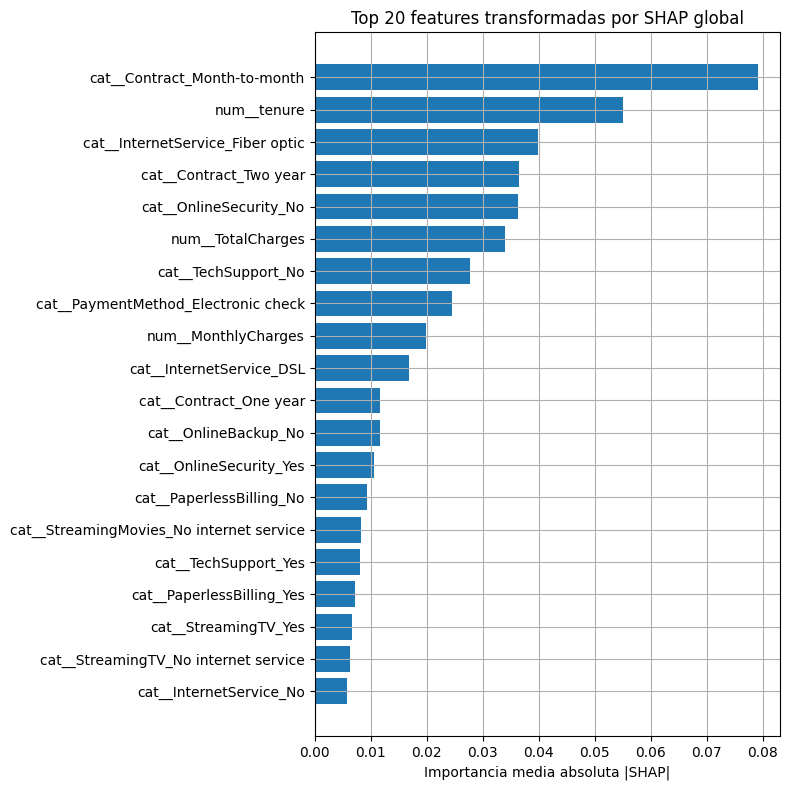

In [27]:
top_n = 20
df_top_shap = df_shap_global.head(top_n).sort_values("mean_abs_shap", ascending=True)

plt.figure(figsize=(8, 8))
plt.barh(df_top_shap["feature"], df_top_shap["mean_abs_shap"])
plt.xlabel("Importancia media absoluta |SHAP|")
plt.title(f"Top {top_n} features transformadas por SHAP global")
plt.tight_layout()
plt.show()

### **Qué observamos en el gráfico SHAP**

❶ **cat__Contract_Month-to-month** es la feature transformada más importante.

* Contribuye positivamente al churn (incrementa riesgo).
* Tiene la mayor media absoluta de SHAP.
* Esto coincide con PFI, validando la consistencia de las explicaciones.

❷ **num__tenure** aparece como el segundo factor más importante.

* Contribuye **negativamente** al churn:
  **cuanto mayor es la antigüedad, menor probabilidad de baja**.
* Esto coincide con el comportamiento real esperado.

❸ **cat__InternetService_Fiber optic** también presenta valores SHAP medios altos.

* Indica mayor riesgo asociado a clientes con fibra óptica.
* Posiblemente por percepción de coste/competencia/precio.

❹ Variables como:

* *TotalCharges*
* *MonthlyCharges*
* *TechSupport_No*
* *OnlineSecurity_No*

tienen impacto moderado pero consistente.

❺ La presencia de múltiples variables *No internet service* o *No OnlineBackup* indica que el modelo está capturando:

* **ausencia de servicios como proxy de bajo engagement**,
* que suele estar asociado a churn en Telco.



### **Diferencias entre PFI y SHAP**


| Aspecto                                     | PFI | SHAP              |
| ------------------------------------------- | --- | ----------------- |
| Trabaja en features originales              | ✔️  | ❌ (one-hot)       |
| Mide causa global (sensibilidad del modelo) | ✔️  | ❌                 |
| Mide contribución al output                 | ❌   | ✔️                |
| Más estable con correlación                 | ❌   | ✔️ (parcialmente) |

* SHAP detecta **interacciones más ricas** gracias al espacio expandido.
* PFI puede subestimar features altamente correlacionadas o con muchos niveles.

El hecho de que ambos métodos concuerden en las features principales aumenta la **fiabilidad explicativa** del modelo.

## 7. Explicabilidad local – SHAP para un cliente individual

Elegimos un cliente concreto del conjunto de test y miramos:

- Su probabilidad de churn estimada.
- Una **explicación local** con SHAP (waterfall) donde se ve
  cómo cada feature contribuye a empujar la predicción hacia churn=1 o churn=0.


In [28]:
i = 0  # puedes cambiar este índice

x_sample = X_test.iloc[[i]]
y_true_sample = y_test.iloc[i]
proba_sample = best_rf_model.predict_proba(x_sample)[:, 1][0]

print("Índice de ejemplo:", x_sample.index[0])
print("Etiqueta real (Churn):", y_true_sample)
print(f"Probabilidad estimada de churn: {proba_sample:.3f}")

display(x_sample)

Índice de ejemplo: 974
Etiqueta real (Churn): 0
Probabilidad estimada de churn: 0.022


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
974,Female,0,Yes,Yes,59,Yes,No,DSL,No,Yes,No,Yes,Yes,Yes,Two year,Yes,Credit card (automatic),75.95,4542.35


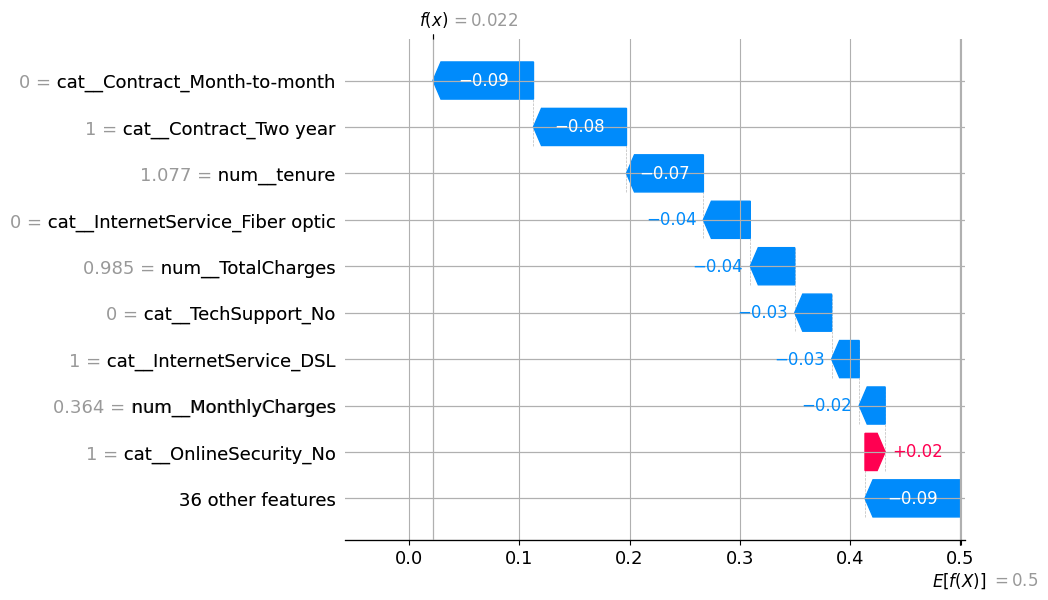

In [31]:
x_sample_trans = pre.transform(x_sample)
if hasattr(x_sample_trans, "toarray"):
    x_sample_trans = x_sample_trans.toarray()

shap_values_sample = explainer(x_sample_trans)

vals = shap_values_sample.values
base = shap_values_sample.base_values
data = shap_values_sample.data if shap_values_sample.data is not None else x_sample_trans
feature_names = getattr(pre, "get_feature_names_out", lambda: np.arange(x_sample_trans.shape[1]))()

if vals.ndim == 3:
    expl_one = shap.Explanation(
        values=vals[0, :, 1],
        base_values=base[0, 1] if np.ndim(base) == 2 else base[1],
        data=data[0],
        feature_names=feature_names,
    )
else:
    expl_one = shap_values_sample[0]

shap.plots.waterfall(expl_one)


### **Interpretación general**

La explicabilidad local responde a:

> **¿Por qué este cliente individual recibe esta predicción concreta?**

SHAP produce una **descomposición aditiva**:

f(x) = base_value + Σ SHAP_i

donde:

* **base_value** ≈ media del modelo (probabilidad media de churn),
* **SHAP_i** = contribución de la feature i,
* azul → disminuye riesgo,
* rojo → aumenta riesgo.

---

### **Qué observamos en el Waterfall**

En tu ejemplo:

* La predicción final es **≈ 0.02** → *muy bajo riesgo de churn*.
* Las barras **azules dominan**:
  el modelo ve muchas señales de retención.

#### Señales que **reducen** la probabilidad de churn:

1. **Contrato “Two year”**:
   Clientes con contrato largo presentan muy pocas bajas.

2. **Tenure alto (59 meses)**:
   Clientes muy antiguos → altamente leales.

3. **Fiber optic = 0** (tiene DSL):
   DSL, sorprendentemente, aparece como menos propenso a churn.

4. **OnlineSecurity = Yes**, o *TechSupport = Yes*:
   Usuarios con servicios añadidos suelen estar más comprometidos.

#### Señales que **aumentan** ligeramente el riesgo:

1. Alguna feature one-hot residual como *OnlineSecurity_No* podría aparecer en rojo.
   Pero su efecto es pequeño porque:

   * los valores numéricos (TotalCharges/MonthlyCharges) son estables,
   * las señales de fidelidad pesan más.

---

### **Explicación a negocio**

> “Este cliente tiene muy baja probabilidad de churn porque:
> está en contrato de dos años, lleva casi 60 meses con la compañía,
> y utiliza servicios adicionales que suelen correlacionar con alta retención.”

Esto convierte SHAP local en una **herramienta de auditoría y toma de decisiones individuales**.



## 8. Sanity check 1 – Reentrenar sin algunas *features*

Un buen sanity check consiste en:

> Eliminar del entrenamiento algunas variables que la explicabilidad global marca como importantes
> y comprobar **cuánto se degrada el modelo**.

Si el modelo apenas cambia, quizá esas variables no eran tan importantes como pensábamos, o bien hay
otras variables muy correlacionadas que absorben su papel.

Aquí probamos, por ejemplo, a eliminar:

- `tenure`
- `Contract`
- `MonthlyCharges`
- `TotalCharges`


In [44]:
drop_features = ["tenure", "Contract", "MonthlyCharges", "TotalCharges"]

print("Features eliminadas en el sanity check:", drop_features)

X_reduced = X.drop(columns=[f for f in drop_features if f in X.columns])

X_train_red, X_test_red, y_train_red, y_test_red = train_test_split(
    X_reduced,
    y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y,
)

categorical_red = X_reduced.select_dtypes(include=["object"]).columns.tolist()
numeric_red = X_reduced.select_dtypes(exclude=["object"]).columns.tolist()

pre_red = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_red),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_red),
    ]
)

rf_red = Pipeline(
    steps=[
        ("pre", pre_red),
        (
            "clf",
            RandomForestClassifier(
                n_estimators=grid.best_params_["clf__n_estimators"],
                max_depth=grid.best_params_["clf__max_depth"],
                min_samples_leaf=grid.best_params_["clf__min_samples_leaf"],
                random_state=RANDOM_STATE,
                class_weight="balanced",
            ),
        ),
    ]
)

rf_red.fit(X_train_red, y_train_red)
y_proba_red = rf_red.predict_proba(X_test_red)[:, 1]
y_pred_red = rf_red.predict(X_test_red)

metrics_red = compute_metrics(y_test_red, y_proba_red, y_pred_red)
display(metrics_to_dataframe(metrics_red))

Features eliminadas en el sanity check: ['tenure', 'Contract', 'MonthlyCharges', 'TotalCharges']


,accuracy,balanced_accuracy,roc_auc,auc_pr,precision_pos,recall_pos,f1_pos,conf_tn,conf_fp,conf_fn,conf_tp
0,0.723525,0.703399,0.782419,0.550636,0.485265,0.660428,0.559456,771,262,127,247


In [45]:
rows = []
for name, m in [("RF_baseline", metrics_rf), ("RF_reduced", metrics_red)]:
    row = {"model": name}
    for k, v in m.items():
        if k == "confusion":
            continue
        row[k] = v
    rows.append(row)

df_compare_rf = pd.DataFrame(rows).set_index("model")
display(df_compare_rf.style.format("{:.4f}"))

,accuracy,balanced_accuracy,roc_auc,auc_pr,precision_pos,recall_pos,f1_pos
model,,,,,,,
RF_baseline,0.7584,0.7493,0.8292,0.6316,0.5332,0.7299,0.6163
RF_reduced,0.7235,0.7034,0.7824,0.5506,0.4853,0.6604,0.5595


Curvas ROC (RF baseline vs RF reducido)


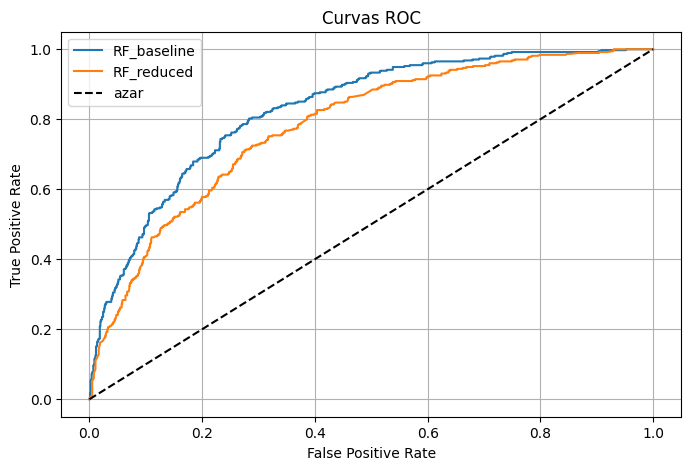

Curvas Precision–Recall (RF baseline vs RF reducido)


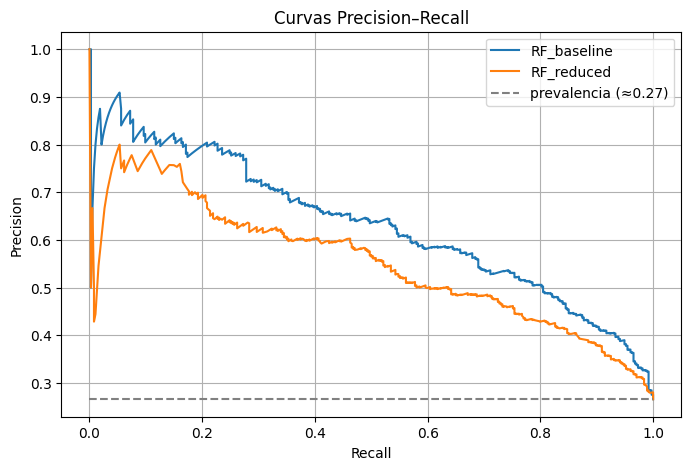

In [46]:
fpr_rf_base, tpr_rf_base, _ = roc_curve(y_test, y_proba_rf)
fpr_rf_red, tpr_rf_red, _ = roc_curve(y_test_red, y_proba_red)

prec_rf_base, rec_rf_base, _ = precision_recall_curve(y_test, y_proba_rf)
prec_rf_red, rec_rf_red, _ = precision_recall_curve(y_test_red, y_proba_red)

print("Curvas ROC (RF baseline vs RF reducido)")
plot_roc_curves(
    {
        "RF_baseline": (fpr_rf_base, tpr_rf_base),
        "RF_reduced": (fpr_rf_red, tpr_rf_red),
    }
)

print("Curvas Precision–Recall (RF baseline vs RF reducido)")
plot_pr_curves(
    {
        "RF_baseline": (rec_rf_base, prec_rf_base),
        "RF_reduced": (rec_rf_red, prec_rf_red),
    },
    baseline_prevalence=prevalence,
)

**Comentario del sanity check 1 (RF baseline vs RF reducido)**

En este experimento eliminamos las cuatro variables que la explicabilidad global marcaba como más relevantes (`tenure`, `Contract`, `MonthlyCharges`, `TotalCharges`) y reentrenamos **otro Random Forest con los mismos hiperparámetros** que el baseline. El objetivo es comprobar si, al quitar esas features, el modelo realmente se degrada.

A nivel de métricas vemos una caída clara:

- **Accuracy** pasa de ≈0.76 a ≈0.72.
- **Balanced accuracy** baja de ≈0.75 a ≈0.70, lo cual es importante porque el problema está desbalanceado.
- **ROC AUC** cae de ≈0.83 a ≈0.78.
- **AUC-PR** (métrica clave en churn) baja de ≈0.63 a ≈0.55.
- En la clase positiva, **precision** pasa de ≈0.53 a ≈0.49 y **recall** de ≈0.73 a ≈0.66 (el F1 también baja de ≈0.62 a ≈0.56).

En las **curvas ROC**, la línea del modelo reducido (naranja) queda por debajo de la del baseline (azul) para casi todos los umbrales, lo que indica que el modelo sin esas variables pierde capacidad de separar bien clientes que se van vs. clientes que se quedan.

En las **curvas Precision–Recall** se aprecia aún mejor el impacto: para niveles de *recall* medios y altos, la **precisión del modelo reducido es sistemáticamente menor**. Además, su curva se acerca más a la línea de prevalencia, mientras que el baseline se mantiene claramente por encima. Esto significa que, cuando intentamos capturar muchos casos de churn, el modelo reducido comete más falsos positivos que el baseline.

En conjunto, este sanity check confirma que:

1. Las variables señaladas por **Permutation FI** y **SHAP global** (`Contract`, `tenure`, `MonthlyCharges`, `TotalCharges`) son realmente críticas para el rendimiento del modelo.
2. La explicabilidad no está “mintiendo”: **si quitamos esas features, el modelo empeora de forma coherente** en todas las métricas relevantes.
3. Aun así, el modelo reducido mantiene cierto rendimiento razonable, lo que sugiere que hay otras variables correlacionadas (por ejemplo, tipo de servicio, método de pago o servicios extra) que capturan parte de la misma información.



## 9. Sanity check 2 – Entrenar con etiquetas barajadas (modelo sin señal)

Segundo sanity check clásico:

> Rompemos la relación entre `X` y `y` barajando las etiquetas de churn
> y volvemos a entrenar el modelo.

Esperamos que:

- **ROC AUC ≈ 0.5**
- **Balanced accuracy ≈ 0.5**
- **AUC-PR ≈ prevalencia de churn**

Si eso no ocurre, podría haber problemas graves (data leakage, implementación incorrecta…).

In [35]:
y_train_shuffled = y_train.sample(frac=1.0, random_state=RANDOM_STATE)

rf_shuffled = Pipeline(
    steps=[
        ("pre", preprocessor),
        (
            "clf",
            RandomForestClassifier(
                n_estimators=grid.best_params_["clf__n_estimators"],
                max_depth=grid.best_params_["clf__max_depth"],
                min_samples_leaf=grid.best_params_["clf__min_samples_leaf"],
                random_state=RANDOM_STATE,
                class_weight="balanced",
            ),
        ),
    ]
)

rf_shuffled.fit(X_train, y_train_shuffled)
y_proba_sh = rf_shuffled.predict_proba(X_test)[:, 1]
y_pred_sh = rf_shuffled.predict(X_test)

metrics_sh = compute_metrics(y_test, y_proba_sh, y_pred_sh)
display(metrics_to_dataframe(metrics_sh))

,accuracy,balanced_accuracy,roc_auc,auc_pr,precision_pos,recall_pos,f1_pos,conf_tn,conf_fp,conf_fn,conf_tp
0,0.624023,0.471031,0.490432,0.246551,0.205323,0.144385,0.169545,824,209,320,54


In [36]:
rows = []
for name, m in [("RF_baseline", metrics_rf), ("RF_shuffled", metrics_sh)]:
    row = {"model": name}
    for k, v in m.items():
        if k == "confusion":
            continue
        row[k] = v
    rows.append(row)

df_compare_sh = pd.DataFrame(rows).set_index("model")
display(df_compare_sh.style.format("{:.4f}"))

,accuracy,balanced_accuracy,roc_auc,auc_pr,precision_pos,recall_pos,f1_pos
model,,,,,,,
RF_baseline,0.7584,0.7493,0.8292,0.6316,0.5332,0.7299,0.6163
RF_shuffled,0.6240,0.4710,0.4904,0.2466,0.2053,0.1444,0.1695


Curvas ROC (RF baseline vs RF shuffled)


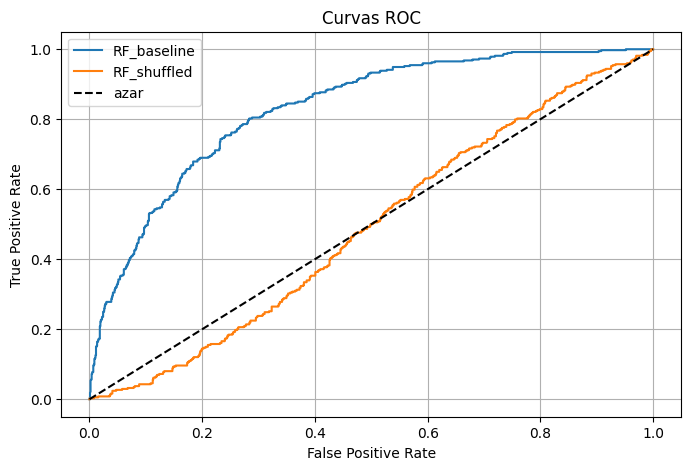

Curvas Precision–Recall (RF baseline vs RF shuffled)


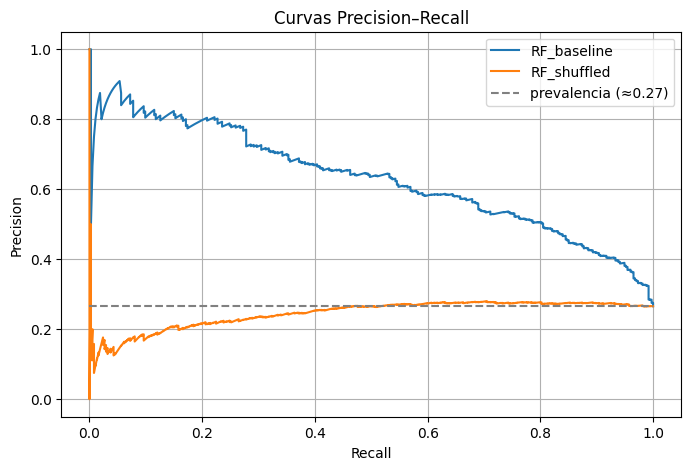

In [37]:
fpr_sh, tpr_sh, _ = roc_curve(y_test, y_proba_sh)
prec_sh, rec_sh, _ = precision_recall_curve(y_test, y_proba_sh)

print("Curvas ROC (RF baseline vs RF shuffled)")
plot_roc_curves(
    {
        "RF_baseline": (fpr_rf_base, tpr_rf_base),
        "RF_shuffled": (fpr_sh, tpr_sh),
    }
)

print("Curvas Precision–Recall (RF baseline vs RF shuffled)")
plot_pr_curves(
    {
        "RF_baseline": (rec_rf_base, prec_rf_base),
        "RF_shuffled": (rec_sh, prec_sh),
    },
    baseline_prevalence=prevalence,
)

# Comentario del Sanity Check 2 (shuffle labels)

En este sanity check barajamos las etiquetas de churn antes de entrenar, de modo que **rompemos totalmente la relación entre las features y la variable objetivo**.
El modelo resultante debería comportarse como **aleatorio** si no hay *data leakage*.

###  Lo que vemos en las métricas

* **ROC AUC = 0.49** → equivalente a tirar una moneda.
* **Balanced accuracy = 0.47** → muy cerca del 0.50 esperado.
* **AUC-PR = 0.246** → prácticamente la prevalencia del churn (~0.27).
* Precision, recall y F1 de la clase positiva se desploman.

### Lo que vemos en las curvas

* **La curva ROC del modelo barajado es casi la diagonal**, señal clara de ausencia de señal.
* **La curva Precision–Recall se aplana cerca de la prevalencia**, comportamiento típico de un clasificador aleatorio.

### Conclusión

El modelo con etiquetas barajadas **no aprende nada útil**, como debe ocurrir.
Esto confirma que:

* el modelo baseline **sí aprende señal real**,
* no hay **data leakage**,
* y las explicaciones XAI del modelo baseline son **fiables**, porque el modelo está capturando estructura auténtica y no ruido.




## 10. Conclusiones

El análisis completo del problema de churn muestra que el modelo **aprende una señal real, estable y coherente con el negocio**. El **Random Forest** ofrece el mejor equilibrio entre *precision*, *recall* y *AUC-PR*, siendo el más adecuado en un entorno desbalanceado.

Las técnicas de explicabilidad global (Permutation FI y SHAP) coinciden al identificar las variables clave: **Contract**, **Tenure**, **InternetService**, **MonthlyCharges** y **TotalCharges**. Esto confirma que el modelo basa sus decisiones en factores lógicos y consistentes con el dominio. La explicabilidad local permite justificar cada predicción de forma transparente, lo que aporta interpretabilidad a nivel individual.

Los dos sanity checks refuerzan la validez del modelo:

* Al **eliminar las features importantes**, el rendimiento cae de forma clara.
* Al **barajar las etiquetas**, el modelo colapsa hacia el azar (AUC ≈ 0.5).

Esto demuestra que **no hay leakage** y que las explicaciones XAI reflejan dependencias reales del dataset.

En conjunto, el pipeline produce un modelo sólido, interpretable y verificado, cumpliendo los requisitos técnicos y de explicabilidad exigidos para un caso de uso de churn en telecomunicaciones.
